In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#import ehtim as eh
from typing import Any, Callable
import functools

import jax
import flax
from flax.serialization import from_bytes
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from skimage import data

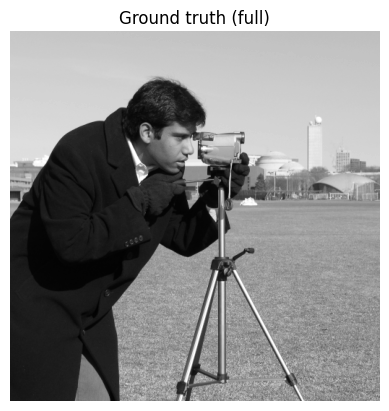

xdim: 512 ydim: 512


In [3]:
img_type = 'camera' # NOTE: change to test on different images

intensity_gt: jnp.array
xdim: int
ydim: int
if img_type == 'black hole':
    import ehtim as eh

    image_path = 'datasets/avery_sgra_eofn.txt'
    array_path = 'datasets/EHT2017.txt'
    image_true = eh.image.load_txt(image_path)
    image_true.display()

    intensity_gt = jnp.array(image_true.imarr(), dtype=jnp.float32)
    ydim, xdim = intensity_gt.shape

    assert intensity_gt.size == image_true.imvec.size
elif img_type == 'camera':
    img = data.camera()
    intensity_gt = jnp.array(img, dtype=jnp.float32) / 255.0
    ydim, xdim = intensity_gt.shape

    assert intensity_gt.size == img.size

    plt.figure()
    plt.title('Ground truth (full)')
    plt.imshow(intensity_gt, cmap='gray')
    plt.axis('off')
    plt.show()
elif img_type == 'starfish':
    # TODO
    pass


# build coords and relevant parameters for later
x, y = np.linspace(0, 1, xdim), np.linspace(0, 1, ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='xy')), 0, -1)
coords_flat = coords.reshape(-1,2)

gt_flat = intensity_gt.ravel()
I_max = float(max(gt_flat))
npix = intensity_gt.size

print('xdim:', xdim, 'ydim:', ydim)

In [13]:
class MLP(nn.Module): 
    net_depth: int = 4
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu 
    out_channel: int = 1
    do_skip: bool = True
  
    @nn.compact
    def __call__(self, x):
        """A simple Multi-Layer Preceptron (MLP) network

        Parameters
        ----------
        x: jnp.ndarray(float32), 
            [batch_size * n_samples, feature], points.
        net_depth: int, 
            the depth of the first part of MLP.
        net_width: int, 
            the width of the first part of MLP.
        activation: function, 
            the activation function used in the MLP.
        out_channel: 
            int, the number of alpha_channels.
        do_skip: boolean, 
            whether or not to use a skip connection

        Returns
        -------
        out: jnp.ndarray(float32), 
            [batch_size * n_samples, out_channel].
        """
        dense_layer = functools.partial(
            nn.Dense, kernel_init=jax.nn.initializers.he_uniform()) 

        if self.do_skip:
            skip_layer = self.net_depth // 2 

        inputs = x
        for i in range(self.net_depth): 
            x = dense_layer(self.net_width)(x)
            x = self.activation(x) 
            if self.do_skip:
                if i % skip_layer == 0 and i > 0:
                    x = jnp.concatenate([x, inputs], axis=-1)
        out = dense_layer(self.out_channel)(x)

        return out

def posenc(x, deg):
    """
    Concatenate `x` with a positional encoding of `x` with degree `deg`.
    Instead of computing [sin(x), cos(x)], we use the trig identity
    cos(x) = sin(x + pi/2) and do one vectorized call to sin([x, x+pi/2]).

    Parameters
    ----------
    x: jnp.ndarray, 
        variables to be encoded. Note that x should be in [-pi, pi].
    deg: int, 
        the degree of the encoding.

    Returns
    -------
    encoded: jnp.ndarray, 
        encoded variables.
    """
    if deg == 0:
        return x
    scales = jnp.array([2**i for i in range(deg)])
    xb = jnp.reshape((x[..., None, :] * scales[:, None]),
                     list(x.shape[:-1]) + [-1])
    four_feat = safe_sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1)) 
    return jnp.concatenate([x] + [four_feat], axis=-1)

class NeuralImage(nn.Module):
    """
    Full function to predict emission at a time step.
    
    Parameters
    ----------
    posenc_deg: int, default=3
    net_depth: int, default=4
    net_width: int, default=128
    activation: Callable[..., Any], default=nn.relu
    out_channel: int default=1
    do_skip: bool, default=True
    """
    posenc_deg: int = 3
    net_depth: int = 4
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu
    out_channel: int = 1
    do_skip: bool = True
    
    @nn.compact
    def __call__(self, coords):
        image_MLP = MLP(self.net_depth, self.net_width, self.activation, self.out_channel, self.do_skip)
        def predict_image(coords):
            net_output = image_MLP(posenc(coords, self.posenc_deg))
            image = I_max*nn.sigmoid(net_output[..., 0])

            return image
        return predict_image(coords)
    
safe_sin = lambda x: jnp.sin(x % (100 * jnp.pi))

In [ ]:
def fourier_forward(image_pred, n_crop):
    """
    Predict the image in Fourier space and crop it in the center
    with dimensions n_crop x n_crop.

    Args:
        image_pred (jnp.ndarray(float32)): the predicted image
        n_crop (int): the size of the crop to take from the center of the Fourier transform
    Returns:
        F_c (jnp.ndarray(float32)): the cropped Fourier transform of the predicted image
    """
    F = jnp.fft.fftshift(jnp.fft.fft2(image_pred, norm = "ortho"))
    cx = (image_pred.shape[1] - n_crop) // 2
    cy = (image_pred.shape[0] - n_crop) // 2
    F_c = jax.lax.dynamic_slice(F, start_indices=(cy, cx), slice_sizes=(n_crop, n_crop))
    return F_c.ravel()


def loss_fn(params, predictor_fn, target, sigma_vis, coords, n_crop):
    '''
    Args:
        params: pytree (nested dict) of all of the model's weights and biases. 
        predictor_fn: the model's apply function
        target: measured intensities
        A: measurement matrix
        sigma: Thermal noise per visibility
        coords: array of shape (N_pixels, 2) with all (x,y) grid coords
    
    Returns:
        image: predicted intensities -> image
        loss: 
    '''
    image_pred = predictor_fn({'params': params}, coords)
    vis = fourier_forward(image_pred, n_crop)
    loss = jnp.mean((jnp.abs(vis - target))**2)
    return loss, image_pred

@functools.partial(jax.jit, static_argnums=(4,))
def train_step(state, target, sigma_vis, coords, n_crop):
    (loss, image), grads = jax.value_and_grad(loss_fn, argnums=(0), has_aux=True)(state.params, state.apply_fn, target, sigma_vis, coords, n_crop)
    state = state.apply_gradients(grads=grads)
    return loss, state, image

predictor = NeuralImage()

In [17]:
"""
Training loop

lets try on black hole image, camera guy, starfish gpt img from brandon (can average over channel axis, can resize w anti aliasing (pil))
also do ensemble on each and compare uncertainty maps. 
"""
n_crop = 128
assert n_crop <= xdim
nvis = n_crop**2
rng_real, rng_im = jax.random.PRNGKey(2), jax.random.PRNGKey(3)

vis_true = fourier_forward(intensity_gt, n_crop)
#if doing n_crop, dont apply noise. 
vis_obs = vis_true
noise = ''
if noise == 'variable':
    uu, vv = np.meshgrid(np.arange(n_crop) - n_crop/2,
                     np.arange(n_crop) - n_crop/2, indexing='ij')
    r = np.sqrt(uu**2 + vv**2) 
    r = r / r.max() # normalize
    sigma_vis = jnp.asarray(1e-2 + 8e-2 * r.ravel(), dtype=jnp.float32)
    noise = sigma_vis * (jax.random.normal(rng_real, (nvis,)) +
                     1j * jax.random.normal(rng_im, (nvis,))) / jnp.sqrt(2)
    vis_obs += noise

    plt.figure()
    plt.imshow(np.log10(np.asarray(sigma_vis).reshape(n_crop, n_crop)), cmap='viridis', origin='lower')
    plt.title('Radial noise map in fourier space')
    plt.xlabel('u')
    plt.ylabel('v')
    plt.colorbar(label='log10 noise')
    plt.tight_layout()
    plt.show()
elif noise == 'uniform':
    sigma_vis = 5e-2 * jnp.ones_like(vis_true, dtype=jnp.float32) #constant noise
    vis_obs += sigma_vis * (jax.random.normal(rng_real, vis_true.shape) + 1j*jax.random.normal(rng_im, vis_true.shape)) / jnp.sqrt(2)
else:
    sigma_vis = jnp.ones_like(vis_true, dtype=jnp.float32) * .5

print(vis_true.shape)
print(vis_obs.shape)
#x, y = np.linspace(0, 1, xdim, endpoint=False), np.linspace(0, 1, ydim, endpoint=False)
#coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)

hparams = {'num_iters': 20000, 'lr_init': 1e-3, 'lr_final': 9e-4, 'batchsize': 500}
params = predictor.init(jax.random.PRNGKey(1), coords)['params']
tx = optax.adam(learning_rate=hparams['lr_init'])
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params, tx=tx)

for i in tqdm(range(hparams['num_iters']), desc='iteration'):
    #batch = np.random.choice(vis_obs.size, hparams['batchsize'], replace=False)
    loss, state, image = train_step(state, vis_obs, sigma_vis, coords, n_crop)
    if i % 1000 == 0:
        print(f"iteration {i}, loss={loss:.9e}")

(16384,)
(16384,)


iteration:   0%|          | 0/20000 [00:00<?, ?it/s]

iteration 0, loss=1.455741405e+00
iteration 1000, loss=8.137679100e-02
iteration 2000, loss=7.305932045e-02
iteration 3000, loss=5.893660337e-02
iteration 4000, loss=5.625256151e-02
iteration 5000, loss=5.235907063e-02
iteration 6000, loss=4.953837022e-02
iteration 7000, loss=4.040192813e-02
iteration 8000, loss=4.280883074e-02
iteration 9000, loss=3.296232224e-02
iteration 10000, loss=3.107034788e-02
iteration 11000, loss=2.777933702e-02
iteration 12000, loss=2.719032764e-02
iteration 13000, loss=2.454165369e-02
iteration 14000, loss=2.258565277e-02
iteration 15000, loss=2.000780031e-02
iteration 16000, loss=2.071253583e-02
iteration 17000, loss=1.889918000e-02
iteration 18000, loss=1.900427043e-02
iteration 19000, loss=1.949835569e-02


(512, 512)


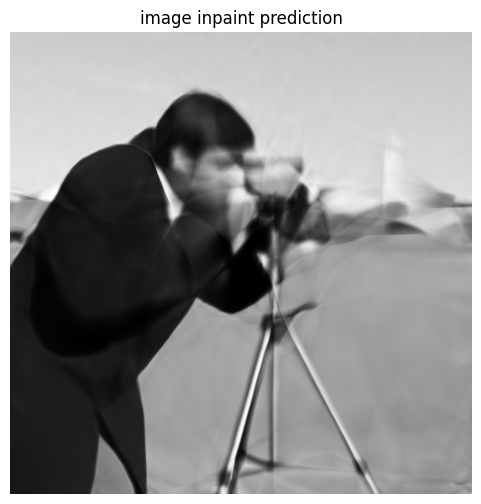

In [18]:
full_image = predictor.apply({'params': state.params}, coords)
full_image = np.array(full_image)
print(full_image.shape)
plt.figure(figsize=(6,6))
cmap = 'gray' if img_type != 'black hole' else 'afmhot'
plt.imshow(full_image, cmap=cmap, origin='upper')
plt.axis('off')
plt.title('image inpaint prediction')
plt.show()

In [25]:
def bilinear(coords, theta):
    """gpt generated function to fill in for now"""
    gx, gy, _ = theta.shape
    # scale to vertex index space
    x = coords[..., 0] * (gx - 1)
    y = coords[..., 1] * (gy - 1)

    i0 = jnp.floor(x).astype(jnp.int32)
    j0 = jnp.floor(y).astype(jnp.int32)
    i1 = jnp.clip(i0 + 1, 0, gx - 1)
    j1 = jnp.clip(j0 + 1, 0, gy - 1)

    wx = x - i0
    wy = y - j0

    # gather four corners
    t00 = theta[i0, j0] # lower-left
    t10 = theta[i1, j0] # lower-right
    t01 = theta[i0, j1] # upper-left
    t11 = theta[i1, j1]  # upper-right

    return ((1 - wx) * (1 - wy))[..., None] * t00 + \
           (wx * (1 - wy))[..., None] * t10 + \
           ((1 - wx) * wy)[..., None] * t01 + \
           (wx * wy)[..., None] * t11

class DeformationGrid(nn.Module):
    resolution: tuple[int, ...]

    @nn.compact
    def __call__(self, coords):
        theta = self.param(
            'theta', 
            nn.initializers.zeros, 
            self.resolution + (coords.shape[-1],)
        )
        return bilinear(coords, theta)

def forward_with_deform(params_img, params_def, coords):
    offsets = DeformationGrid.apply({'params': params_def}, coords)
    return predictor.apply({'params': params_img}, coords + offsets)

grid_res = (80, 80)
def_grid = DeformationGrid(grid_res)

In [26]:
'''prepare variables for bayes rays'''

params_img = state.params
params_img_frozen = jax.tree_util.tree_map(jnp.array, params_img)

params_def = def_grid.init(
    jax.random.PRNGKey(0), 
    jnp.array([[0, 0]]))['params']
params_def = jax.tree_util.tree_map(jnp.zeros_like, params_def)

In [27]:

def forward_visibility(params_def, coords):
    """
    add offset and get updated visibility matrix
    """
    offsets = def_grid.apply({'params': params_def}, coords)
    img_pred = predictor.apply({'params': params_img_frozen}, coords + offsets)
    return fourier_forward(img_pred, n_crop)

# compute derivatives of real and imaginary parts independently--otherwise H not differentiable
def re_vis(params_def, k):
    """Re(eps_theta(r))"""
    return jnp.real(forward_visibility(params_def, coords)[k])

def im_vis(params_def, k):
    """Im(eps_theta(r))"""
    return jnp.imag(forward_visibility(params_def, coords)[k])

#take the gradient of a forward_visibility (real or imaginary) over k visibilities
def flatten(tree):
    return jnp.concatenate([t.ravel() for t in jax.tree_util.tree_leaves(tree)])

def grad_row(fn, k):
    g_tree = jax.grad(fn)(params_def, k)
    return flatten(g_tree['theta'])

# compute hessian in chunks
@functools.partial(jax.jit, static_argnums=(1,))
def chunk(idx, fn, sigma_batch):
    J = jax.vmap(lambda k: grad_row(fn, k))(idx) # evaluate grad_row over each i \in idx
    J = J.reshape((J.shape[0], -1))
    if noise:
        J = J / (sigma_batch[:, None] / jnp.sqrt(2))
        #J = J / (sigma_batch[:, None])
    return J.T @ J

def fisher_sum(chunk_size, P, lam, nvis):
    """
    Can no longer assume sigma^2 = 1/2 or use abs in loss fn. Take the derivative of the real and imaginary parts
    and compute in chunks of rows to avoid OOM. 
    
    Args:
        chunk_size: number of rows of the jacobian to evaluate in one step
        res: grid resolution, (xdim, ydim); 2D for now
    Returns:
        J_sq: = sum( (J_re_n^2 + J_im_n^2) / sigma_n^2)
    """
    #J_sq = jnp.zeros((res[0], res[1], 2))
    
    H = jnp.zeros((P, P))
    for start in tqdm(range(0, nvis, chunk_size), desc='iteration'):
        end = min(start+chunk_size, nvis)
        idx = jnp.arange(start, end)
        H += chunk(idx, re_vis, sigma_vis[idx])+chunk(idx, im_vis, sigma_vis[idx])

        #J_sq += chunk(idx, re_vis, sigma_vis[idx]) + chunk(idx, im_vis, sigma_vis[idx])
    
    return H

In [29]:
chunk_size = 10
P = 2 * grid_res[0] * grid_res[1] #number of parameters in the grid
lam = 3e-5/(grid_res[0]*grid_res[1])
H = fisher_sum(chunk_size, P, lam, nvis)

H *= 4/nvis
if not noise:
    H *= sigma_vis[0]
H += 2.0 * lam * jnp.eye(P)

#H_diag = (4*H)/(nvis) + 2.0*lam *jnp.eye(P) # deterministic H, no monte carlo

V = jnp.linalg.inv(H)

"""print(V.shape)
variance_grid = jnp.diag(V).reshape(grid_res[0], grid_res[1], 2)
print(variance_grid.shape)
sigma_map = jnp.linalg.norm(
    jnp.sqrt(bilinear(coords, variance_grid)), 
    axis=-1
)"""

iteration:   0%|          | 0/1639 [00:00<?, ?it/s]

'print(V.shape)\nvariance_grid = jnp.diag(V).reshape(grid_res[0], grid_res[1], 2)\nprint(variance_grid.shape)\nsigma_map = jnp.linalg.norm(\n    jnp.sqrt(bilinear(coords, variance_grid)), \n    axis=-1\n)'

Approximate $\Sigma = H^{-1}$ as $$B(u)\Sigma B(u)^T$$

Hessian Condition: 5218843600.0


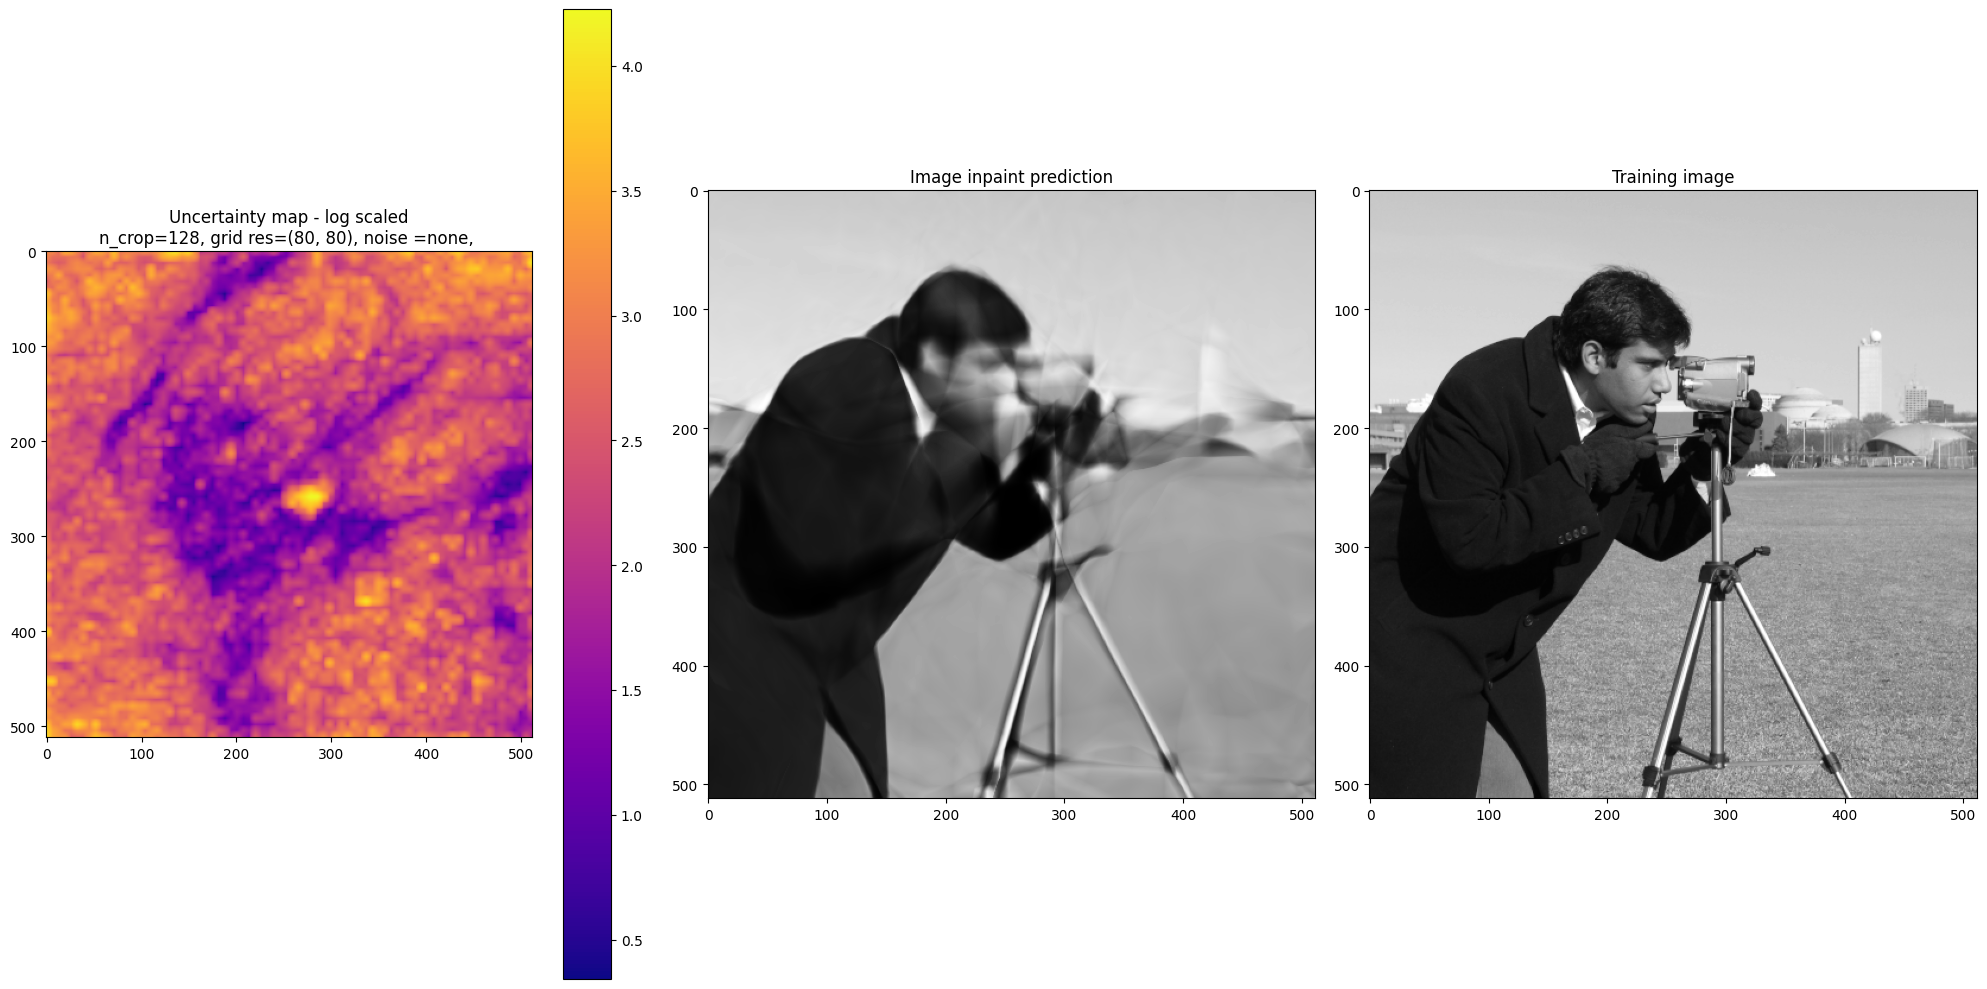

In [30]:
"""must use n_crop^2 > P, otherwise rank(H) << P and variances explode for unconstrained deformation parameters"""

print("Hessian Condition:", jnp.linalg.cond(V))

gx, gy = grid_res
def flat_idx(i, j, channel): # channel=0(x) or 1(y)
    return 2 * (i*gy + j) + channel

@jax.jit
def build_W_and_idx(u):
    """
    Build the bilinear weight matrix and neighboring weight indicies for effective batching so we dont OOM
    Note that the batching is deterministic. 
    """
    ux, uy = u
    x = ux * (gx-1)
    y = uy * (gy-1)
    i0, j0 = jnp.floor(x).astype(int), jnp.floor(y).astype(int)
    i1, j1 = jnp.minimum(i0+1, gx-1), jnp.minimum(j0+1, gy-1)
    wx, wy = x - i0, y - j0

    # four vertex weights
    w  = jnp.array([
        (1-wx)*(1-wy),
        wx *(1-wy),
        (1-wx)*wy,
        wx *wy,
    ])
    idx = jnp.array([
        flat_idx(i0,j0,0), flat_idx(i0,j0,1),
        flat_idx(i1,j0,0), flat_idx(i1,j0,1),
        flat_idx(i0,j1,0), flat_idx(i0,j1,1),
        flat_idx(i1,j1,0), flat_idx(i1,j1,1),
    ]) # length-8

    #sigma_sub = V[idx[:,None], idx[None,:]]  # (8,8) sub matrix of neighboring bilinear interpolation weights
    W = jnp.stack([ # 2×8
        jnp.reshape(jnp.repeat(w,2)[0::2], (4,)), # x-weights
        jnp.reshape(jnp.repeat(w,2)[1::2], (4,)), # y-weights
    ], axis=0).repeat(2, axis=1)[:,:8]
    
    return idx, W
    '''C = W @ sigma_sub @ W.T
    return jnp.sqrt(jnp.trace(C))'''

def make_unc_fn(Sigma):
    """
    Function to handle both a diagonal and full hessian computation.
    Later, we compare the diagonal with the full hessian.
    """
    is_diag = Sigma.ndim==1

    @jax.jit
    def pixel_sigma(u):
        idx, W = build_W_and_idx(u)
        if is_diag:
            sigma_sub = jnp.diag(Sigma[idx])
        else:
            sigma_sub = Sigma[idx[:,None], idx[None,:]]
        return jnp.sqrt(jnp.trace(W @ sigma_sub @ W.T))
    return pixel_sigma

# vectorise over pixels in manageable chunks
def sigma_map_from_coords(coords, Sigma, chunk=8192):
    """
    compute the full uncertainty map from bayes rays, evaluating at 
    each point in coords
    """
    c_flat = coords.reshape(-1,2)
    unc_fn = make_unc_fn(Sigma)
    out = []
    for k in range(0, c_flat.shape[0], chunk):
        out.append(jax.vmap(unc_fn)(c_flat[k:k+chunk]))
    return jnp.concatenate(out).reshape(coords.shape[:2])

def vis_to_image(vis_vec, n_crop, full_N=xdim):
    """to visualize the magnitude of noise added (note it was added in fourier space)"""
    uv = np.zeros((full_N, full_N), dtype=np.complex64)
    cx = (full_N - n_crop) // 2
    cy = (full_N - n_crop) // 2
    uv[cy:cy+n_crop, cx:cx+n_crop] = vis_vec.reshape(n_crop, n_crop)
    return np.fft.ifft2(np.fft.ifftshift(uv)).real

# bilinear upsample
grid_coords = np.stack(np.meshgrid(np.linspace(0, 1, gx), np.linspace(0, 1, gy), indexing='xy'), axis=-1)
sigma_map = sigma_map_from_coords(grid_coords, V).reshape(gx, gy)
sigma_map = bilinear(coords, sigma_map[..., None]).squeeze(-1)

full_image = predictor.apply({'params': state.params}, coords)

fig, ax = plt.subplots(1, 3, figsize=(20,10))
im_0 = ax[0].imshow(jnp.log10(sigma_map + 1e-12), cmap='plasma', origin="upper")
noise_str = ''
if not noise:
    noise_str = 'none'
elif noise == 'variable':
    noise_str = noise + "_1e-2-9e-2_radial"
elif noise == 'uniform':
    noise_str = noise + str(sigma_vis[0])

ax[0].set_title(f"Uncertainty map - log scaled\nn_crop={n_crop}, grid res={grid_res}, noise ={noise_str}, ")
im_1 = ax[1].imshow(full_image, cmap=cmap, origin='upper')
ax[1].set_title('Image inpaint prediction')
if noise:
    im_2 = ax[2].imshow(vis_to_image(vis_obs, n_crop), cmap=cmap, origin='upper')
    ax[2].set_title('Noisy training image')
else:
    im_2 = ax[2].imshow(intensity_gt, cmap=cmap)
    ax[2].set_title('Training image')
plt.tight_layout()
fig.colorbar(im_0, ax=ax[0])

save = True
if save:
    plt.savefig(f'cameraman_unc_results/n_crop{n_crop}_grid_res{grid_res[0]}x{grid_res[1]}_noise_{noise_str}.png')

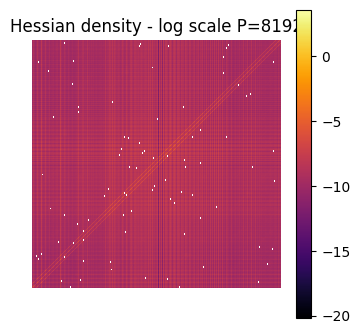

In [33]:
def plot_H_pattern(H, title="Hessian sparsity"):
    """Visualise |H|—white = zero(ish), dark = non-zero."""
    plt.figure(figsize=(4,4))
    plt.imshow(jnp.log10(jnp.abs(H)), cmap='inferno', origin='lower')
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()

plot_H_pattern(H, f"Hessian density - log scale P={P}")


In [34]:
off = H - jnp.diag(jnp.diag(H))
ratio = jnp.linalg.norm(off) / jnp.linalg.norm(H)
print("condition: ",jnp.linalg.cond(H))
print("‖off‖ / ‖H‖ =", float(ratio))


sigma_full_map = sigma_map_from_coords(coords, V) #the full matrix
sigma_diag_map = sigma_map_from_coords(coords, jnp.diag(V)) # only the diagonal of covariance matrix
rel_err = jnp.mean(jnp.abs(sigma_full_map - sigma_diag_map) /
                   (sigma_full_map + 1e-12)) # relative L1 error to decide if diag is good enough
print("relative L1 error (diag vs full) =", float(rel_err))

"""can calculate a chunk of off diagonals perhaps"""

condition:  1314001500000.0
‖off‖ / ‖H‖ = 0.6527645587921143
relative L1 error (diag vs full) = 0.4236377477645874


'can calculate a chunk of off diagonals perhaps'

Because the off-diagonal energy is high and the per-pixel Laplace
uncertainty shifts by ∼ 50 % when those terms are ignored, we cannot rely
on a diagonal Fisher in the Fourier-imaging case.
For credible uncertainty maps we need at least the 8 × 8 sub-block
method (or a low-rank/CG alternative), not the simple diagonal that
Bayes Rays uses for NeRF.

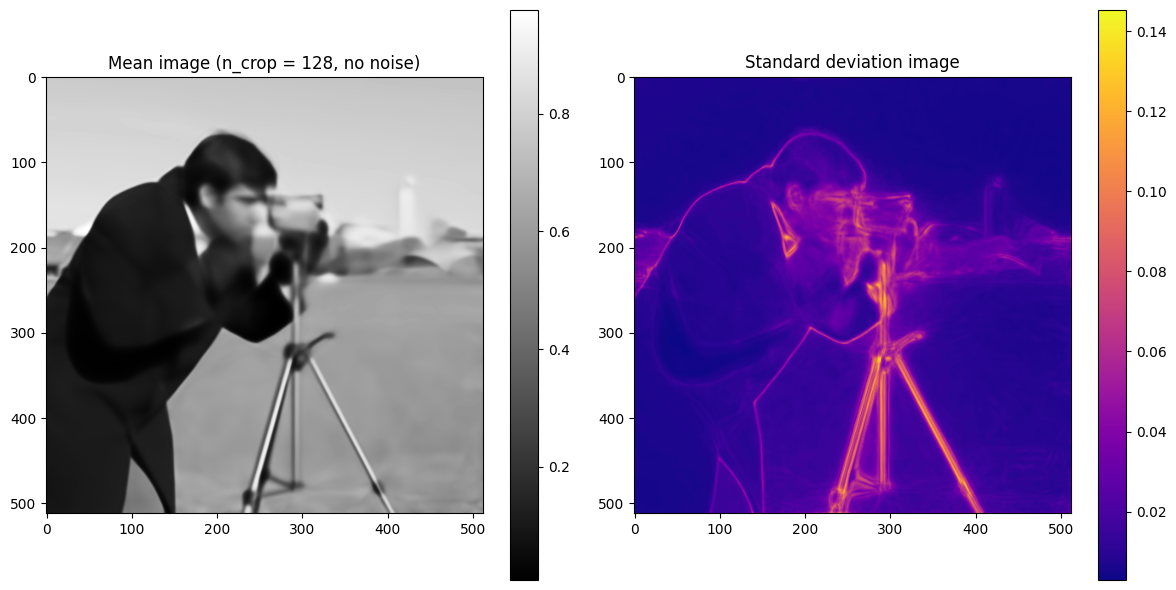

In [12]:
import os

x, y = np.linspace(0, 1, xdim), np.linspace(0, 1, ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='xy')), 0, -1)
coords_flat = coords.reshape(-1,2)
ensemble = []
preds = []
predictor = NeuralImage()
template = predictor.init(jax.random.PRNGKey(0), coords)['params']
for fname in sorted(os.listdir(os.path.join("camera_ensemble", "models"))):
    if not fname.endswith(".msgpack"): 
        continue
    data = open(os.path.join("camera_ensemble", "models", fname), "rb").read()
    params = from_bytes(template, data)
    ensemble.append(params)
    preds.append(np.array(predictor.apply({"params": params}, coords)))

E = np.stack(preds, axis=0)
mean_img = E.mean(axis=0)
std_img = E.std(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im0 = ax[0].imshow(mean_img, cmap='grey')
ax[0].set_title("Mean image (n_crop = 128, no noise)")
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(std_img, cmap='plasma')
ax[1].set_title("Standard deviation image")
fig.colorbar(im1, ax=ax[1])
plt.tight_layout()
plt.savefig('cameraman_unc_results/naive_ensemble_n_crop128.png')